# Week 8: Introduction to Support Vector Machines

----------------------------------------------------
Machine Learning     Year 2019/2020

*Vanessa Gómez Verdejo vanessa@tsc.uc3m.es* and *Pablo M. Olmos olmos@tsc.uc3m.es*

----------------------------------------------------

[Support vector machines (SVMs)](http://scikit-learn.org/stable/modules/svm.html) are a particularly powerful and flexible class of supervised algorithms for both classification and regression.
In this section, we will develop the intuition behind support vector machines and their use in classification problems.

Recommended Bibliography:

- Chapter 7 of [Pattern Recognition and Machine Learning](https://cds.cern.ch/record/998831/files/9780387310732_TOC.pdf), Christopher Bishop, 2006
- Chapter 17 of [Bayesian Reasoning and Machine Learning](http://web4.cs.ucl.ac.uk/staff/D.Barber/textbook/090310.pdf), David Barber, 2010
- Chapter 14 of Machine Learning: a probabilistic perspective, Kevin Murphy 2012
- This excellent [post](http://efavdb.com/svm-classification/) by Andrew Ng. 

We begin with the standard imports:

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats


# use seaborn plotting defaults
import seaborn as sns; sns.set()

Consider the simple case of a classification task, in which the two classes of points are well separated. 

Notes:
* You can check out first what the [make blobs](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html) function does.

* And you want to learn about color maps in matplotlib check [here](https://matplotlib.org/users/colormaps.html)

The shape of X is  (100, 2)
y is a label vector. The first 10 labels are: [-1 -1  1  1  1  1 -1 -1  1  1]


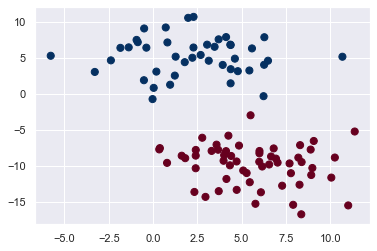

In [2]:
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=500, centers=2,
                  random_state=10, cluster_std=3)    #With random_state we fix the random seed

# Define the labels as -1, +1
y = 2*y-1

#We separate away some data for test
X_test = X[100:,:] 
y_test = y[100:]

X = X[:100,:]
y = y[:100]

print("The shape of X is ",X.shape)

print("y is a label vector. The first 10 labels are:", y[:10])

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu')

plt.rcParams["figure.figsize"] = [8,8]


A linear discriminative classifier would attempt to draw a straight line separating the two sets of data, and thereby create a model for classification. **However, note there are many possible solutions!!**


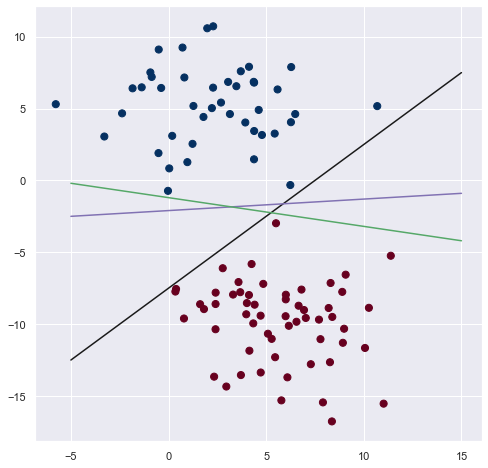

In [3]:
xfit = np.linspace(-5, 15)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu')

m,b = (1, -7.5)
plt.plot(xfit, m * xfit + b, '-k')

m,b = (0.08, -2.1)
plt.plot(xfit, m * xfit + b, '-m')

m,b = (-0.2,-1.2)
plt.plot(xfit, m * xfit + b, '-g')

plt.rcParams["figure.figsize"] = [8,8]

**Which one do you think separates best the data?**

Let's plot some *test data* with the right category.

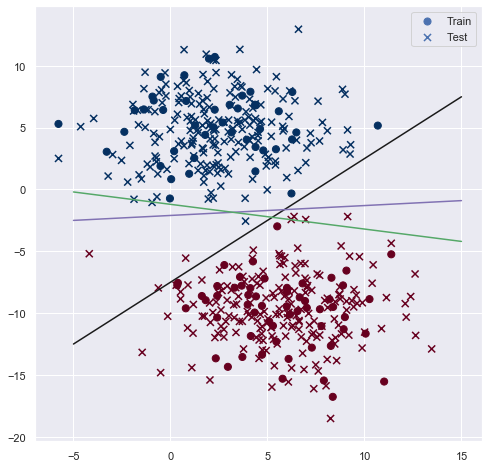

In [4]:
xfit = np.linspace(-5, 15)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu',label='Train')

plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=50, cmap='RdBu',marker='x',label='Test')

plt.legend()

m,b = (1, -7.5)
plt.plot(xfit, m * xfit + b, '-k')

m,b = (0.08, -2.1)
plt.plot(xfit, m * xfit + b, '-m')

m,b = (-0.2,-1.2)
plt.plot(xfit, m * xfit + b, '-g')


plt.rcParams["figure.figsize"] = [8,8]

## Maximizing the *Margin*

SVMs offer one way to improve on this.
The intuition is this: rather than simply drawing a zero-width line between the classes, we can draw around each line a *margin* of some width, up to the nearest point. The largest the margin is, the more robust the model is and generalizes better.

Here is an example of how this might look:

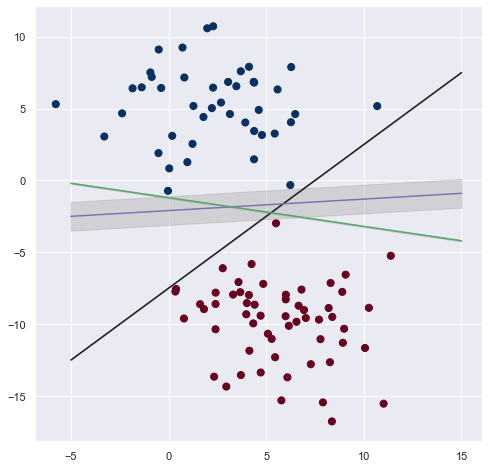

In [5]:
xfit = np.linspace(-5, 15)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu')


m,b,d = (1, -7.5,0.01)
yfit = m * xfit + b
plt.plot(xfit,yfit, '-k')
plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',color='#AAAAAA', alpha=0.4)

m,b,d = (0.08, -2.1, 1)
yfit = m * xfit + b
plt.plot(xfit,yfit, '-m')
plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',color='#AAAAAA', alpha=0.4)

m,b,d = (-0.2,-1.2,0.05)
yfit = m * xfit + b
plt.plot(xfit,yfit, '-g')
plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',color='#AAAAAA', alpha=0.4)

plt.rcParams["figure.figsize"] = [8,8]

In SVMs, the line that maximizes this margin is the one we will choose as the optimal model.
SVMs are an example of such a *maximum margin* estimator.

## A little bit of geometry: hyperplanes

### Hyperplanes

First of all, for $\mathbf{x}\in\mathbb{R}^D$, consider the function
\begin{align}
f(\mathbf{x}) = \mathbf{w}^T\mathbf{x}+w_0
\end{align}

Then, the set of points $\mathbf{x}\in\mathbb{R}^D$ such that $f(\mathbf{x})=0$ is called an [**hyperplane**](http://mathworld.wolfram.com/Hyperplane.html), a subspace of dimension $D-1$. E.g., for $D=2$, then the hyperplane is a line. For $D=3$ is a plane.

#### Some useful results with hyperplanes

  <img align="right" src="http://www.tsc.uc3m.es/~vanessa/Figs_notebooks/ML/SVMs/Fig1.png" width="40%" >
  <br>

1. If $\mathbf{x}_A$ and $\mathbf{x}_B$ are two points in the hyperplane, then the vector $\mathbf{v}=\alpha(\mathbf{x}_A-\mathbf{x}_B)$ is orthogonal to $\mathbf{w}$ for $\alpha\in\mathbb{R}$. Thus, $\mathbf{w}$ is orthogonal to any vector contained in the hyperplane and it determines the orientation of the hyperplane.
<br><br>

  *Proof*: If $\mathbf{x}_A$ and $\mathbf{x}_B$ are two points in the hyperplane, then $\mathbf{w}^T\mathbf{x}_A+w_0=\mathbf{w}^T\mathbf{x}_B+w_0=0$. Thus, $\mathbf{w}^T\left(\mathbf{x}_A-\mathbf{x}_B\right)=0$. 

<br><br><br><br><br>

 <img align="right" src="http://www.tsc.uc3m.es/~vanessa/Figs_notebooks/ML/SVMs/Fig2.png" width="40%" >
 <br>

2. The normal distance between the origin $\mathbf{0}$ and the closest point in the hyperplane is given by $-\frac{w_0}{||\mathbf{w}||}$, where a negative distance denotes that the hyperplane lies below the origin, and $||\mathbf{w}||=\sqrt{\mathbf{w}^T\mathbf{w}}$.
<br><br>

  *Proof*: Note that, for any $\mathbf{x}$ (not necesarily in the hyperplane), the projection of $\mathbf{x}$ into $\mathbf{w}$ is the dot product between $\mathbf{x}$ and a normalized vector of $\mathbf{w}$, thus $\mathbf{x}_{\perp}=\frac{ \mathbf{w}^T\mathbf{x}}{||\mathbf{w}||}$.  Note that this projection is the distance from the origin to the hyperplane orthogonal to $ ||\mathbf{w}||$ that passes through $\mathbf{x}$. If $\mathbf{x}$ is a point of the hyperplane, $f(\mathbf{x}) = \mathbf{w}^T\mathbf{x}+w_0 =$, so 

$$
\mathbf{x}_{\perp}=\frac{ -w_0}{||\mathbf{w}||}
$$
<br><br><br>

  <img align="right" src="http://www.tsc.uc3m.es/~vanessa/Figs_notebooks/ML/SVMs/Fig3.png" width="40%" >
<br>

3. The normal distance to any point $\mathbf{x}^*\in\mathbb{R}^D$ to the hyperplane is $ \frac{f(\mathbf{x}^*)}{||\mathbf{w}||}$. This distance is positive for points above the hyperplane, and negative for points below the hyperplane.
<br><br>

  *Proof*: Given any point $\mathbf{x}$ in the hyperplane $f(\mathbf{x}) = \mathbf{w}^T\mathbf{x}+w_0=0$, the normal distance of $\mathbf{x}^*$ to the hyperplane is the proyection of $(\mathbf{x}^*-\mathbf{x})$ into $\mathbf{w}$ (since $\mathbf{w}$ is perpedincular to the plane). Hence

$$
\text{distance} = \frac{\mathbf{w}^T(\mathbf{x}^*-\mathbf{x})}{||\mathbf{w}||}=\frac{\mathbf{w}^T\mathbf{x}^*-\mathbf{w}^T\mathbf{x}}{||\mathbf{w}||}=\frac{\mathbf{w}^T\mathbf{x}^*+w_0}{||\mathbf{w}||}=\frac{f(\mathbf{x}^*)}{||\mathbf{w}||}
$$

# Support Vector Machines: The linearly separable case

Assume there exists an hyperplane that separates our data $\mathcal{D}=(\mathbf{x}^{(i)},y^{(i)})$, $i=1,\ldots,N$, where $\mathbf{x}^{(i)}\in\mathbb{R}^D$ and $y^{(i)}\in\{-1,+1\}$. Then, there must exist an hyperplane $f(\mathbf{x}) = \mathbf{w}^T\mathbf{x}+w_0=0$ that verifies
\begin{align}
y^{(i)}f(\mathbf{x}^{(i)})\geq 0, ~~ \forall (\mathbf{x}^{(i)},y^{(i)})
\end{align}

## The SVM: maximizing the margin

If we want to maximize the classification margin, we have to maximize the distance of the closest point to the hyperplane, so the SVM optimization problem reads as follows

\begin{align}
\arg\max_{\mathbf{w},w_0} \left\{ \min_{i} \frac{y^{(i)}f(\mathbf{x}^{(i)})}{||\mathbf{w}||}\right\}
\end{align}

However, trying to solve this optimization problem would be too complex, but it can be written in a simpler way. Since the distance of any point $\mathbf{x}^{(i)}$ to the hyperplane is invariant to a scale of the form $\mathbf{w}\leftarrow \eta\mathbf{w}$, $w_0\leftarrow\eta w_0$, **then we can freely set the minimum distance to the hyperplane to $||\mathbf{w}||$**, rescaling the whole problem. Thus, any point in the training set must verify

\begin{align}
y^{(i)}f(\mathbf{x}^{(i)})\geq 1, ~~ \forall (\mathbf{x}^{(i)},y^{(i)})
\end{align}


<center> <img src="http://www.tsc.uc3m.es/~vanessa/Figs_notebooks/ML/SVMs/Fig4.png" width="40%"> </center>

And the equivalent problem can be written follows:

\begin{align}
&\min_{\mathbf{w},w_0}  ~~~ \frac{1}{2} ||\mathbf{w}||^2\\
\text{s. t.}~~~ &y^{(i)}f(\mathbf{x}^{(i)})\geq 1, ~ i=1,\ldots,N
\end{align}

where we have modified the minimization of $||\mathbf{w}||^{-1}$ by the maximization of $||\mathbf{w}||^2$ and we have introduced the factor $\frac{1}{2}$ for later convenience. This optimization problem is an example of a [**Quadratic Programming (QP)**](https://sites.math.washington.edu/~burke/crs/408f/notes/qp/qp1.pdf) optimization problem. Very efficient solvers are known for these kind of problems. Complexity scales cubic in the input dimension, i.e., $\mathcal{O}(D^3)$.



Let's run this model and visualize the solution for our running example.

In [6]:
from sklearn.svm import LinearSVC # "Support vector classifier"
model = LinearSVC(C=1E20)   # We explain later the role of C
model.fit(X, y)

LinearSVC(C=1e+20, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [7]:
print(model.coef_)
print(model.intercept_)

[[-0.04943704  0.76557489]]
[1.55515955]


The following function plots the SVM decision boundaries for us:

In [8]:
def plot_svc_decision_function(model, ax=None):
    """Plot the decision function for a 2D SVC"""
    if ax is None:            #If no figure handle is provided, it opens the current figure
        ax = plt.gca()
        
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)    #30 points in the grid axis
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)                 # We create a grid with the x,y coordinates defined above
    
    # From the grid to a list of (x,y) values. 
    # Check Numpy help for ravel()
    
    xy = np.vstack([X.ravel(), Y.ravel()]).T 
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    # In levels we provide a list of floating point numbers indicating 
    #the level curves to draw, in increasing order; e.g., to draw just the zero contour pass
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

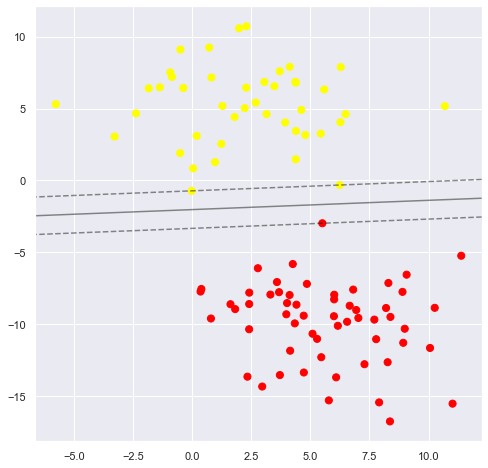

In [9]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model)

plt.rcParams["figure.figsize"] = [8,8]

# Going depeer into the SVM solution: the dual formulation

There's lot more that we can say about how SVM perform. To this end, we have to go deeper into the optimization problem itself:

\begin{align}
&\min_{\mathbf{w},w_0}  ~~~ \frac{1}{2} ||\mathbf{w}||^2\\
\text{s.t.}~~~ & y^{(i)}f(\mathbf{x}^{(i)})\geq 1, ~ i=1,\ldots,N
\end{align}

## Introducing Lagrange Multipliers

Given the constraints of the problem, the Lagrange function that has to be optimized is of the form

\begin{align}
\mathcal{L}(\mathbf{w},w_0,\mathbf{a}) = \frac{1}{2}||\mathbf{w}||^2 -\sum_{i=1}^N a^{(i)} (y^{(i)}f(\mathbf{x}^{(i)})-1),
\end{align}
where $a^{(i)}\geq 0$, $i=1,\ldots,N$ are the Lagrange multipliers (we have introduced a multiplier for each constraint). If we compute the gradient of $\mathcal{L}(\mathbf{w},w_0,\mathbf{a})$ w.r.t. $\mathbf{w}$ and $w_0$ and equalize to zero, we get the following conditions:
1. $$\mathbf{w} =\sum_{i=1}^N a^{(i)} y^{(i)} \mathbf{x}^{(i)}$$ 
2. $$ 0 = \sum_{i=1}^{N} a^{(i)}  y^{(i)}$$

## The Dual Problem
If we introduce the above expressions in the the Lagrange function, our optimization problem reads

\begin{align}
&\max_{\mathbf{a}}  ~~~~ \sum_{i=1}^{N}a^{(i)} -\frac{1}{2}\sum_{i=1}^N \sum_{j=1}^N a^{(i)} a^{(j)} {\mathbf{x}^{(i)}}^\top\mathbf{x}^{(j)}\\
\text{s.t.} ~~~~ & a^{(i)} \geq 0, ~ i=1,\ldots,N\\
& 0  = \sum_{i=1}^{N} a^{(i)}  y^{(i)}
\end{align}

This problem is another instance of **Quadratic Programming** and its resolution is also $\mathcal{O}(N^3)$ complex. Note that it is solved for dual variables $\mathbf{a}$.

However, given the solutionfor $\mathbf{a}$, we can recover the weight vector using the condition (1):

\begin{align}
\mathbf{w} =\sum_{i=1}^N a^{(i)} y^{(i)} \mathbf{x}^{(i)}
\end{align}

Note that the weigth vector is a linear combination of the training data!!!!. And we can classify a new point $\mathbf{x}^*$ according to the sign of
\begin{align}
f(\mathbf{x}^*) = \sum_{i=1}^{N} a^{(i)} y^{(i)} {\mathbf{x}^{(i)}}^\top\mathbf{x}^*+w_0
\end{align}

In which scenarios do you think it is preferable to use the primal formulation (solving for $\mathbf{w}$ and $w_0$) or in the dual (solving for $\mathbf{a}$)?

## SVMs are sparse! 

There is even more we can say about the SVM solution. In fact, we will see that when we get the  dual variables $a_1, \ldots, a_N$ most of their values are zero. So the SVM solution is determined only by a **subset** of training points, which are known as **support vectors**.

Despite we do not prove it, given the problem
\begin{align}
&\max_{\mathbf{a}}  ~~~~ \sum_{i=1}^{N}a^{(i)} -\frac{1}{2}\sum_{i=1}^N \sum_{j=1}^N a^{(i)} a^{(j)} y^{(i)} y^{(j)} {\mathbf{x}^{(i)}}^\top\mathbf{x}^{(j)}\\
\text{s.t.} ~~~~ & a^{(i)} \geq 0, ~ i=1,\ldots,N\\
& 0  = \sum_{i=1}^{N} a^{(i)}  y^{(i)}
\end{align}

the [**Karush-Kuhn-Tucker (KKT)**](http://www.onmyphd.com/?p=kkt.karush.kuhn.tucker) conditions require that the solution of the problem must verify, for $i=1,\ldots,N$, the following:

  1. $a^{(i)}\geq 0$
  2. $y^{(i)}f(\mathbf{x}^{(i)})-1\geq 0$
  3. $a^{(i)}\left(y^{(i)}(f(\mathbf{x}^{(i)})-1)\right)=0$

If you want to understand how to prove these results, check out Appendix E in Bishop's book.

## Support Vectors

Contidion (3) implies that, for any point in our training set, either $a^{(i)}=0$ or $f(\mathbf{x}^{(i)})-1 = 0$. This means that either the point **do not participate in the SVM solution** or that the point lies **exactly in the margin**. Points for which $a^{(i)}>0$ are called **support vectors (SVs)** and are the only ones defining the separation hyperplane:

\begin{align}
\mathbf{w} &=\sum_{i: a^{(i)}>0} a^{(i)} y^{(i)} \mathbf{x}^{(i)}
\end{align}
and the prediction for future values:
\begin{align}
f(\mathbf{x}^*) &= \sum_{i: a^{(i)}>0} a^{(i)} y^{(i)} {\mathbf{x}^{(i)}}^\top\mathbf{x}^*+w_0
\end{align}

The fraction of SVs w.r.t. to the total number of training points must be read as a measure of the complexity of the model and how much it is exposed to **overfitting**. The more we have, the poorest generalization we can expect.


Besides, SVs can help us to find the value $w_0$, since we know that any support vector satisfies $y^{(i)}f( \mathbf{x}^{(i)}) = 1$, so:
$$y^{(i)} \left( \sum_{i: a^{(i)}>0} a^{(i)} y^{(i)} {\mathbf{x}^{(i)}}^\top\mathbf{x}^{(i)} +w_0 \right) = 1$$
and (averaging over all SVs)
$$w_0 = \frac{1}{N_S}\sum_{i: a^{(i)}>0} \left(y^{(i)}-\sum_{j: a^{(j)}>0} a^{(j)} y^{(j)}{\mathbf{x}^{(j)}}^\top\mathbf{x}^{(i)}\right)$$


Let's plot the support vectors in our example.

In [10]:
from sklearn.svm import SVC # "Support vector classifier using the dual formulation"
model = SVC(kernel='linear', C=1E10)   # We use a linear kernel (no transformation), we will explain during next session.
                                       # Also, we explain below the role of C
model.fit(X, y)

SVC(C=10000000000.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [11]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:            #If no figure handle is provided, it opens the current figure
        ax = plt.gca()
        
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)    #30 points in the grid axis
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)                 # We create a grid with the x,y coordinates defined above
    
    # From the grid to a list of (x,y) values. 
    # Check Numpy help for ravel()
    
    xy = np.vstack([X.ravel(), Y.ravel()]).T 
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    # In levels we provide a list of floating point numbers indicating 
    #the level curves to draw, in increasing order; e.g., to draw just the zero contour pass
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, marker='+')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

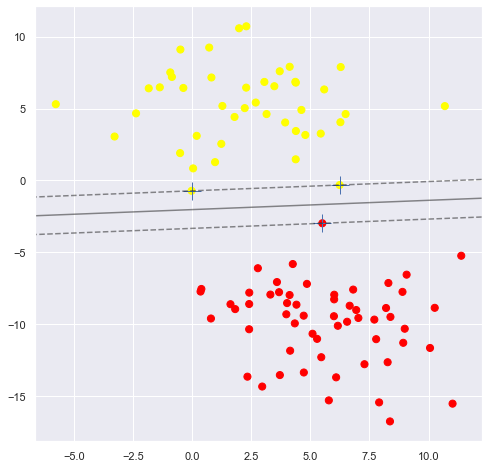

In [12]:
plt.figure()

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model, plot_support=True)


## Exercise 1

## Exercise 1.1

Analyze the model that we have just trained. Check the following parameters:
* model.n_support_
* model.support_
* model.support_vectors_
* model.dual_coef_

In [13]:
# <SOL>
print(model.n_support_) # how many of each type (y=-1 and y=1)
print(model.support_)  # the data points indexes
print(model.support_vectors_) # the vectors themselves
print(model.dual_coef_) # Lagrange value times y_i
# </SOL>

[1 2]
[76 44 65]
[[ 5.50383564 -2.9820617 ]
 [-0.02793398 -0.72696356]
 [ 6.23671868 -0.32241735]]
[[-0.29423756  0.04231224  0.25192532]]


## Exercise 1.2

Use these parameters to compute the weigth vector ($\mathbf{w}$) and the intercept term ($w_0$). Check that the obtained solution matches that saved in the model parameters coef_ and intercept_. Besides, you can also check this solution with that provided by the primal problem resolution. 

In [0]:
# <SOL>
print('The model parameters are w:',model.coef_,'and w0:',model.intercept_)

w = np.dot(model.dual_coef_ , model.support_vectors_)[0]

Ns = len(model.support_)
first_sum = 0.
for j in range(Ns):
  first_sum += model.dual_coef_[0][j] * model.support_vectors_[j,:].T

w0 = 0.
for i in range(Ns):
  if (model.dual_coef_[0][i] > 0): y = 1 
  else: y = -1
  w0 += y - np.dot(first_sum,model.support_vectors_[i,:])
w0 = w0/Ns

print('Computed with the dual formulation, \nthe model parameters are w:',w,'and w0:',w0)
# </SOL>

The model parameters are w: [[-0.04942979  0.76545   ]] and w0: [1.55493987]
Computed with the dual formulation, 
the model parameters are w: [-0.04942979  0.76545   ] and w0: 1.5549400382912655


# Support Vector Machines: Dealing with non-separable datasets

So far, the whole SVM formulation builds up over the assumption that the data is separable by an hyperplane. I.e., that there exists an hyperplane $f(\mathbf{x}) = \mathbf{w}^T\mathbf{x}+w_0=0$ that verifies
\begin{align}
y^{(i)}f(\mathbf{x}^{(i)})\geq 1, ~~ \forall (\mathbf{x}^{(i)},y^{(i)}),
\end{align}
where points holding the equality are the support vectors. 

In order to **relax** this assumption and prevent **overfitting**, we could allow certain **training** points to be missclassified. We introduce the so-called **slack** variables:

\begin{align}
y^{(i)}f(\mathbf{x}^{(i)})\geq 1-\xi^{(i)}, ~~ \forall (\mathbf{x}^{(i)},y^{(i)})
\end{align}
where $\xi^{(i)}\geq 0$:
- Training points for which $\xi^{(i)} = 0 $ are correctly classified and outside the SVM margin:  $y^{(i)}f(\mathbf{x}^{(i)}) > 1$.
- Training points for which $\xi^{(i)}\leq 1$ are correctly classified but inside the margin:  $0<y^{(i)}f(\mathbf{x}^{(i)}) < 1$.
- Training points for which $\xi^{(i)} > 1$ are in the wrong side of the decision boundary: $y^{(i)}f(\mathbf{x}^{(i)}) < 0$.

<center> <img src="http://www.tsc.uc3m.es/~vanessa/Figs_notebooks/ML/SVMs/Fig5.png" width="40%" ></center>

## Optimization problem with slack variables

The optimization problem can now be written as follows:
\begin{align}
&\min_{\mathbf{w},w_0} = \frac{1}{2} ||\mathbf{w}||^2 + C \sum_{i=1}^{N}\xi^{(i)}\\
\text{s. t.}~~~~ & y^{(i)}f(\mathbf{x}^{(i)})\geq 1-\xi^{(i)}, ~ i=1,\ldots,N\\
&\xi^{(i)}\geq 0, ~ i=1,\ldots,N
\end{align}

where the $C$ parameter is introduced to control the regularization. For $C\rightarrow\infty$ we recover the original SVM formulation, as the  solution tends to $\xi^{(i)}=0$ for $i=1,\ldots,N$.

Now, the Lagrange function to be optimized is

\begin{align}
\mathcal{L}(\mathbf{w},w_0,\mathbf{a},\mathbf{b}) = \frac{1}{2} ||\mathbf{w}||^2+ C \sum_{i=1}^{N}\xi^{(i)} -\sum_{i=1}^N a^{(i)} (y^{(i)}f(\mathbf{x}^{(i)})-1+\xi_i)-\sum_{i=1}^{N}b^{(i)}\xi^{(i)}
\end{align}

### KKT conditions

The KKT conditions associated to the new optimization problem are, for $i=1,\ldots,N$,  as follows:

1. $\xi^{(i)}\geq 0$
2. $a^{(i)}\geq 0$
3. $b^{(i)}\geq 0$
4. $b^{(i)} \xi^{(i)} = 0$
5. $y^{(i)}f(\mathbf{x}^{(i)})-1 + \xi^{(i)} \geq 0$
6. $ a^{(i)}\left(y^{(i)}f(\mathbf{x}^{(i)}-1 +\xi^{(i)} \right) = 0$

### Support Vectors

As before, the last condition implies that, for any point in our training set, either $a^{(i)}=0$ or $f(\mathbf{x}^{(i)})-1+\xi^{(i)} = 0$. This means that either:
* the point **do not participate in the SVM solution** ($a^{(i)}=0$), 
* the point lies **exactly in the margin** ($y^{(i)}f(\mathbf{x}^{(i)})=1$ and $\xi^{(i)} = 0$), 
* or the point is **inside the margin or wrongly classified** ($\xi^{(i)} = 1 - y^{(i)}f(\mathbf{x}^{(i)})>0$).

Points for which $a^{(i)}>0$ are called **support vectors** and are the only ones defining the separation hyperplane and the prediction for future values!

### Dual problem

If we compute the gradient Lagrange function w.r.t. $\mathbf{w}$, $w_0$ and $\xi_i$ and equalize to zero we get the following conditions

\begin{align}
\mathbf{w} &=\sum_{i=1}^N a^{(i)} y^{(i)} \mathbf{x}^{(i)}, ~~~~~~
0 = \sum_{i=1}^{N} a^{(i)}  y^{(i)}, ~~~~~~~ a^{(i)} = C-b^{(i)}
\end{align}

If we substitute them in the Lagrange function, we derive the folowing dual optimization problem, 
\begin{align}
&\max_{\mathbf{a}}  ~~~~ \sum_{i=1}^{N}a^{(i)} -\frac{1}{2}\sum_{i=1}^N \sum_{j=1}^N a^{(i)} a^{(j)} y^{(i)} y^{(j)}{\mathbf{x}^{(i)}}^\top\mathbf{x}^{(j)}\\
\text{s.t.} ~~~~ & 0\leq a^{(i)} \leq C, ~ i=1,\ldots,N\\
& 0  = \sum_{i=1}^{N} a^{(i)}  y^{(i)}
\end{align}

which is also a quadratic problem with complexity $\mathcal{O}(N^3)$.

###  The hinge error function

We have seen that data lying on the correct side of the margin ($y^{(i)}f(\mathbf{x}^{(i)})>1$) have $\xi^{(i)}= 0$, whereas remaining points have $\xi^{(i)}= 1- y^{(i)}f(\mathbf{x}^{(i)})$; so, we can write the SVM formulation as:

$$\mathbf{w}^* =\displaystyle \underset{{\bf w}}{\operatorname{min}}\sum_{i=1}^N  \left[ 1 - f(\mathbf{x}^{(i)}) y^{(i)}\right]_+ + \frac{1}{2C} ||\mathbf{w}||^2 $$  
where $[\cdot]_+$ denotes the positive part. This cost function, known as **hinge loss**, is un upper bound of the classification error.

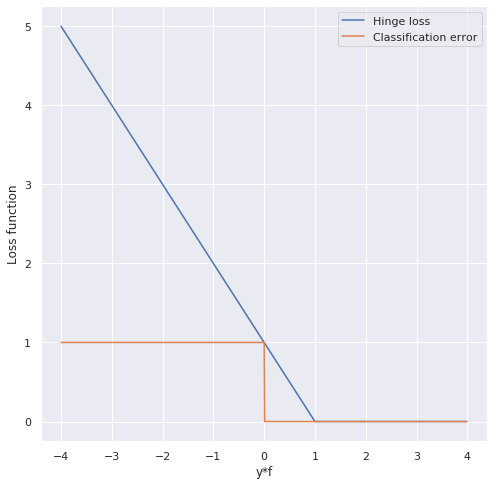

In [0]:
# Plot the hinge loss function (un upper bound of the classfication error)
f = np.arange(-4,4,0.01)
y = 1
l_w = 1-y*f
l_w[l_w<0]=0
plt.figure()
plt.plot(y*f,l_w, label='Hinge loss')


# Classification error
e_class = np.zeros(f.shape)
e_class[y*f<0] =1
plt.plot(y*f,e_class, label='Classification error')

plt.legend()
plt.xlabel('y*f')
plt.ylabel('Loss function')

plt.show()

Now, let's play with a non-linearly separable data set. So, let's generate a new dataset...

The shape of X is  (100, 2)


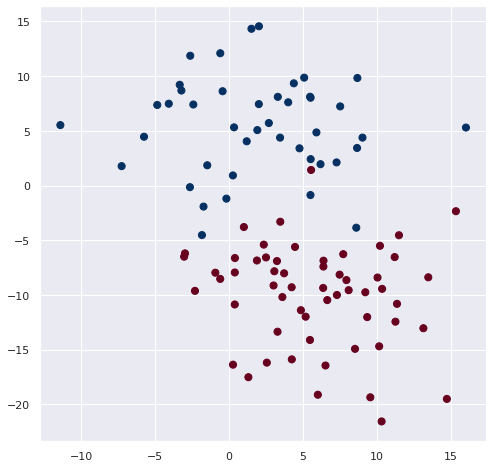

In [0]:
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=500, centers=2,
                  random_state=10, cluster_std=5)    #With random_state we fix the random seed

# Define the labels as -1, +1
y = 2*y-1

#We separate away some data for test
X_test = X[100:,:] 
y_test = y[100:]

X = X[:100,:]
y = y[:100]

print("The shape of X is ",X.shape)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu')

plt.rcParams["figure.figsize"] = [8,8]


## Exercise 2

Train a linear SVM to solve the classification problem that we have just defined. Analyze its solution for different values of the C parameter (0.01, 1, 100, 1e4, 1e6):
* Plot the classification problem and the given solution.
* Analyze the number of SVs and the margin width.
* Plot the SVs. Which SVs are on the margin, inside the margin or wrongly classified? 

You could train the linear SVM using either its primal or dual SVM implementation. However, to be able to analyze the SVs, use the dual one: [SVC()](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html).

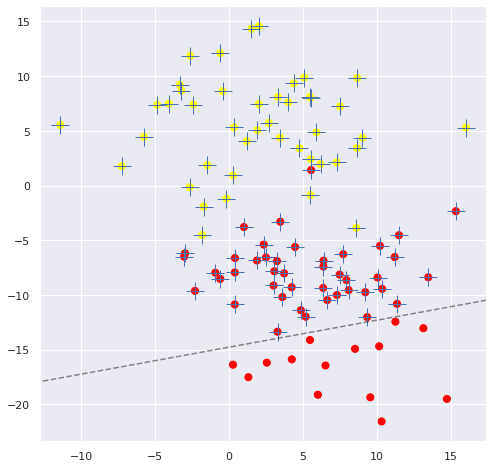

0.002280712127685547


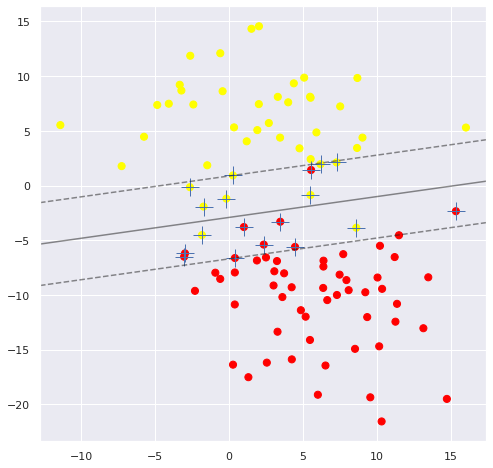

0.0018322467803955078


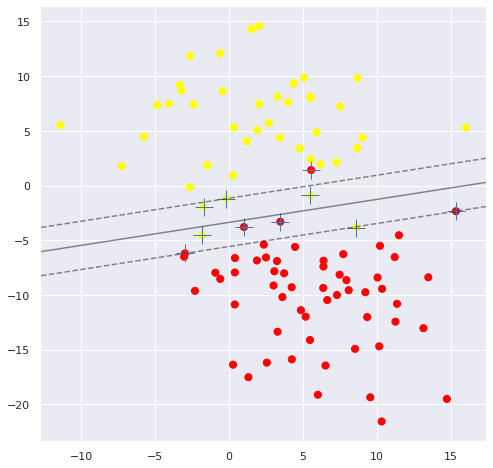

0.003774404525756836


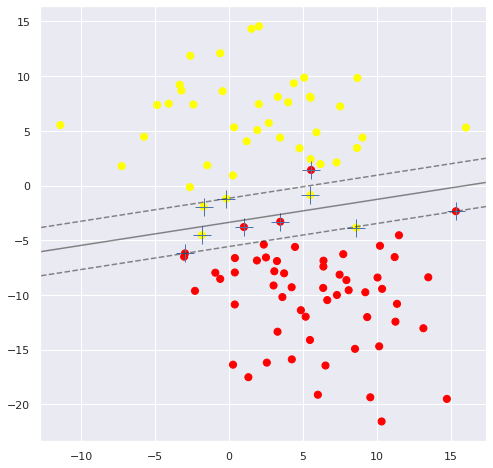

0.006600856781005859


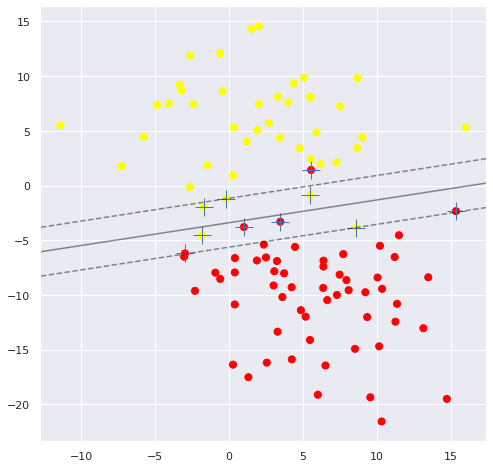

0.17033743858337402


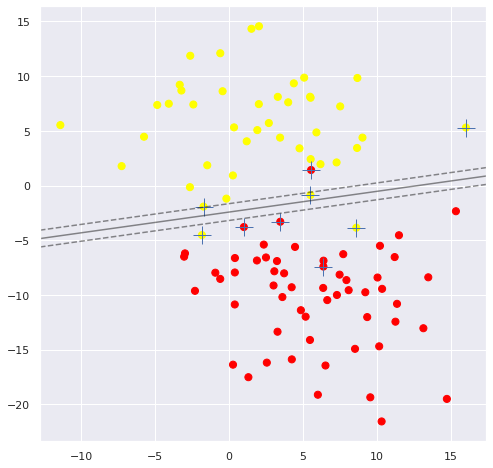

21.263567686080933


In [0]:
# <SOL>
import sklearn
import time
SV = []

C_vector = [0.00001, 0.01, 1, 100, 1e4, 1e6]
for i,c in enumerate(C_vector):
  t = time.time()
  SV.append(sklearn.svm.SVC(C=c,kernel='linear'))
  SV[i].fit(X,y)
  t2 = time.time()
  plt.figure()
  plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
  plot_svc_decision_function(SV[i], plot_support=True)
  plt.show()
  print(t2-t)
# </SOL>


# SVMs in multiclass problems

When we have to face a multiclass problems, some classifiers are inherently multiclass (for instance, K-Nearest Neighbours); however,  other ones, such as the SVM, have been designed for the binary case. So, when we have to deal with multipclass problems, we have to convert our multiclass problem in a set of binary ones. There are two main strategies for this:

### One vs. one
* It trains a binary classifier per pair of classes. 
* At prediction time, the class which receives the most votes is selected. 
* It requires to train $\frac{M (M - 1)}{2}$ classifiers.
* Each individual learning problem involves a small subset of the data.

### One vs. all
* It defines binary problems fitting each class against the remaining classes. 
* Only $M$ classifiers are trained (computational efficiency).
* A gain of interpretability (each class is represented by one classifier).
* This is the most commonly used strategy.

By default, Scikit-learn implements all classifiers in a one vs. all fashion. However, to let the user select the multiclass implementation to be used, it also includes two wrapper functions that work over the classifier to force the multiclass strategy to be applied: [OneVsRestClassifier( )](http://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html#sklearn.multiclass.OneVsRestClassifier) and [OneVsOneClassifier( )](http://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsOneClassifier.html#sklearn.multiclass.OneVsOneClassifier). 


## Exercise 3

The following code builds a bidimensional problem with four classes and 500 samples, it creates the training and testing partitions with the 60% and 40% of the original data and, it normalizes the data to zero mean and unitary standard deviation.

In [0]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Initialize the random generator seed to compare results
np.random.seed(0)

# Generating artifial data
X, Y = datasets.make_classification(n_samples=500, n_features=2, n_classes = 4, n_clusters_per_class=1,
                                    class_sep=2, n_redundant=0, flip_y =0.01)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.4)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Considering as default classifier a linear SVM ( with C=100), obtain two different multiclass configurations: one vs. all and one vs. one. For this purpose, you can use the functions: [OneVsRestClassifier( )](http://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html#sklearn.multiclass.OneVsRestClassifier) and [OneVsOneClassifier( )](http://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsOneClassifier.html#sklearn.multiclass.OneVsOneClassifier). 

Check the number of classifiers that are built by each configuration (you can use access to the .estimators\_ parameter of the resulting classifier object). Finally, compute their classification accuracies over the test data.

When you complete your code, you can use next function to plot the classification boundaries.



In [0]:
# Plot the decision boundary
def plot_multiclass_boundary(clf, X, Y):
    """Plot the classification regions for a given classifier.

    Args:
        clf: scikit-learn classifier object.
        X (numpy dnarray): training or test data to be plotted (number data x number dimensions). Only frist two 
                            dimensions are ploted
        Y (numpy dnarray): labels of the training or test data to be plotted (number data x 1).
        plt: graphic object where you wish to plot                                             
   
    """

    plot_colors = "brymc"
    plot_step = 0.02
    plt.figure()
        

    n_classes = np.unique(Y).shape[0]
    # Plot the decision regions
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                        np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)

    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.axis("tight")

    # Plot the training points
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(Y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=color, cmap=plt.cm.Paired)

    plt.axis("tight")

Number of estimators is 4
Train accuracy is 0.9600 and test accuracy is 0.9550


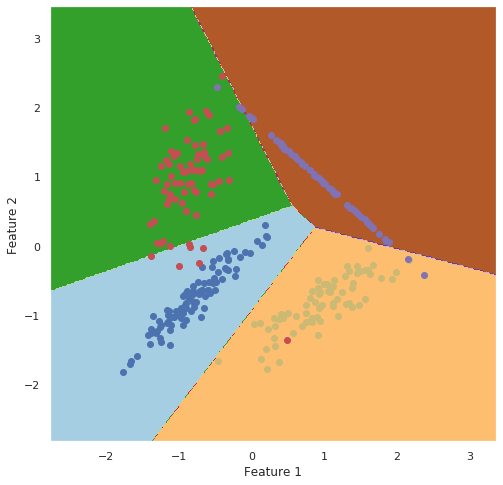

In [0]:
# <SOL>
from sklearn.multiclass import OneVsRestClassifier
clfs = OneVsRestClassifier(sklearn.svm.SVC(C=100,kernel='linear'))
clfs.fit(X_train,Y_train)
print('Number of estimators is %d' %len(clfs.estimators_))

plot_multiclass_boundary(clfs, X_train, Y_train)

acc_train = clfs.score(X_train,Y_train)
acc_test  = clfs.score(X_test,Y_test)
print('Train accuracy is %.4f and test accuracy is %.4f' %(acc_train,acc_test))
# </SOL>

Number of estimators is 6
Train accuracy is 0.9833 and test accuracy is 0.9750


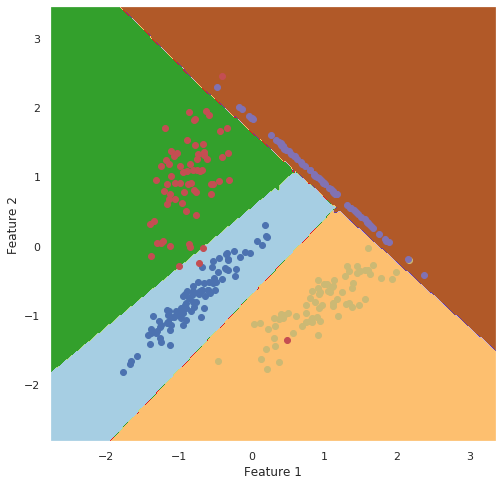

In [0]:
# <SOL>
from sklearn.multiclass import OneVsOneClassifier
clfs = OneVsOneClassifier(sklearn.svm.SVC(C=100,kernel='linear'))
clfs.fit(X_train,Y_train)
print('Number of estimators is %d' %len(clfs.estimators_))

plot_multiclass_boundary(clfs, X_train, Y_train)

acc_train = clfs.score(X_train,Y_train)
acc_test  = clfs.score(X_test,Y_test)
print('Train accuracy is %.4f and test accuracy is %.4f' %(acc_train,acc_test))
# </SOL>